# Load SRL


In [1]:
# load pkl from data\srls\mfc\FRISS_srl.pkl

import pickle

with open("../../data/srls/mfc/mfc_labeled.pkl", "rb") as f:
    data = pickle.load(f)

print(data.keys())

Index(['article_id', 'text', 'srls'], dtype='object')


In [5]:
# create statistics

num_preds = []

for k, v in data.items():
    num_preds.append(len(v))

print("Number of predicates per sentence")
print("Mean:", sum(num_preds) / len(num_preds))
print("Max:", max(num_preds))
print("Min:", min(num_preds))
print("Number of sentences:", len(num_preds))

Number of predicates per sentence
Mean: 67480.0
Max: 67480
Min: 67480
Number of sentences: 3


In [7]:
data.iloc[0].to_dict()

{'article_id': 'Immigration1.0-10005',
 'text': 'Immigrants without HOPE need help entering college Anxiety gripped Jose Alvarado in third-period calculus class at North Atlanta High School.',
 'srls': [{'predicate': 'need',
   'ARG0': 'Immigrants without HOPE',
   'ARG1': 'help entering college Anxiety'},
  {'predicate': 'entering',
   'ARG0': 'Immigrants without HOPE',
   'ARG1': 'college Anxiety'},
  {'predicate': 'gripped',
   'ARG0': 'Immigrants without HOPE need help entering college Anxiety',
   'ARG1': 'Jose Alvarado'}]}

# Load MRC preprocessed Data


In [4]:
# data\mfc\data_prepared.json
import pandas as pd

with open("../../data/mfc/data_prepared.json", "r") as f:
    data_prepared = pd.read_json(f)

In [5]:
data_prepared.shape

(67480, 18)

In [6]:
# preprocess text

import re


def preprocess_text(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("  ", " ")
    text = text.strip()

    # some texts start with "IMM-XXXXX PRIMARY" remove
    text = re.sub(r"^IMM-\d+ PRIMARY", "", text)

    # remove leading and trailing whitespaces
    text = text.strip()

    return text


data_prepared["text"] = data_prepared["text"].apply(preprocess_text)

In [7]:
data_prepared.head()

,article_id,text,document_frame,Capacity and Resources,Crime and Punishment,Cultural Identity,Economic,External Regulation and Reputation,Fairness and Equality,Health and Safety,"Legality, Constitutionality, Jurisdiction",Morality,Other,Policy Prescription and Evaluation,Political,Public Sentiment,Quality of Life,Security and Defense
0,Immigration1.0-10005,Immigrants without HOPE need help entering col...,Quality of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Immigration1.0-10005,It mounted as students went around the room te...,Quality of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Immigration1.0-10005,Georgia Tech.,Quality of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Immigration1.0-10005,University of Georgia.,Quality of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Immigration1.0-10005,"""All I could say was, 'I'm planning to see if ...",Quality of Life,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
# stats for text length

text_lengths = data_prepared["text"].apply(len)

In [9]:
text_lengths.describe()

count    67480.000000
mean       139.985803
std         78.341919
min          1.000000
25%         81.000000
50%        130.000000
75%        188.000000
max       1102.000000
Name: text, dtype: float64

In [10]:
df_sample = data_prepared.copy()

In [11]:
# save to json
df_sample.to_json("../../data/mfc/data_prepared_cleaned.json", orient="records")

In [12]:
import pandas as pd

# load
with open("../../data/mfc/data_prepared_cleaned.json", "r") as f:
    df = pd.read_json(f)

df.shape

(67480, 18)

# Load frameaxis


In [13]:
import pickle

# load data\frameaxis\mfc\frameaxis_contextualized_mft.pkl

with open("../../data/frameaxis/mfc/frameaxis_mft.pkl", "rb") as f:
    data_fa = pickle.load(f)

data_fa.shape

(67480, 12)

In [14]:
data_fa

,article_id,text,care_bias,care_intensity,loyalty_bias,loyalty_intensity,authority_bias,authority_intensity,fairness_bias,fairness_intensity,sanctity_bias,sanctity_intensity
0,Immigration1.0-10005,Immigrants without HOPE need help entering col...,0.046806,0.001429,-0.072163,0.004429,-0.120223,0.005293,-0.089829,0.003872,-0.100013,0.001405
1,Immigration1.0-10005,It mounted as students went around the room te...,0.033659,0.001912,-0.096215,0.002419,-0.124081,0.001463,-0.134707,0.006858,-0.106475,0.000591
2,Immigration1.0-10005,Georgia Tech.,-0.013455,0.005673,-0.187340,0.014931,-0.031740,0.006546,-0.003253,0.005017,-0.068036,0.002993
3,Immigration1.0-10005,University of Georgia.,0.030489,0.000623,-0.134004,0.009003,-0.061839,0.004271,-0.006635,0.004705,-0.039451,0.005877
4,Immigration1.0-10005,"""All I could say was, 'I'm planning to see if ...",0.050968,0.001929,-0.141105,0.011773,-0.163692,0.007566,-0.144491,0.011913,-0.112075,0.001787
...,...,...,...,...,...,...,...,...,...,...,...,...
67475,Immigration1.0-9998,"Sue Brown, spokeswoman for the INS, said it's ...",0.062358,0.001915,-0.104728,0.004193,-0.113421,0.002445,-0.092194,0.003707,-0.111625,0.002539
67476,Immigration1.0-9998,"""They love it,"" she said.",0.024687,0.001381,-0.204733,0.022664,-0.237031,0.020564,-0.206741,0.018972,-0.133000,0.001048
67477,Immigration1.0-9998,"""They use these units to interview the people,...",0.073612,0.003475,-0.116507,0.007126,-0.176678,0.008782,-0.110437,0.005405,-0.070875,0.003934
67478,Immigration1.0-9998,"""We do about 15 interviews a day,"" Brown said.",0.035231,0.003923,-0.125450,0.005931,-0.125360,0.004460,-0.104501,0.005406,-0.111736,0.001030


In [15]:
# join data_fa with df on row-wise

df_fa = pd.concat([df_sample, data_fa], axis=1)

df_fa.shape

(73811, 30)

In [16]:
# keep 'article_id', 'text', 'care_bias', 'care_intensity', 'loyalty_bias', 'loyalty_intensity', 'authority_bias', 'authority_intensity', 'fairness_bias', 'fairness_intensity', 'sanctity_bias', 'sanctity_intensity'

df_fa = df_fa[
    [
        "article_id",
        "text",
        "care_bias",
        "care_intensity",
        "loyalty_bias",
        "loyalty_intensity",
        "authority_bias",
        "authority_intensity",
        "fairness_bias",
        "fairness_intensity",
        "sanctity_bias",
        "sanctity_intensity",
    ]
]

df_fa.head()

,article_id,article_id,text,text,care_bias,care_intensity,loyalty_bias,loyalty_intensity,authority_bias,authority_intensity,fairness_bias,fairness_intensity,sanctity_bias,sanctity_intensity
0,Immigration1.0-10005,Immigration1.0-10005,Immigrants without HOPE need help entering col...,Immigrants without HOPE need help entering col...,0.046806,0.001429,-0.072163,0.004429,-0.120223,0.005293,-0.089829,0.003872,-0.100013,0.001405
1,Immigration1.0-10005,Immigration1.0-10005,It mounted as students went around the room te...,It mounted as students went around the room te...,0.033659,0.001912,-0.096215,0.002419,-0.124081,0.001463,-0.134707,0.006858,-0.106475,0.000591
2,Immigration1.0-10005,Immigration1.0-10005,Georgia Tech.,Georgia Tech.,-0.013455,0.005673,-0.187340,0.014931,-0.031740,0.006546,-0.003253,0.005017,-0.068036,0.002993
3,Immigration1.0-10005,Immigration1.0-10005,University of Georgia.,University of Georgia.,0.030489,0.000623,-0.134004,0.009003,-0.061839,0.004271,-0.006635,0.004705,-0.039451,0.005877
4,Immigration1.0-10005,Immigration1.0-10005,"""All I could say was, 'I'm planning to see if ...","""All I could say was, 'I'm planning to see if ...",0.050968,0.001929,-0.141105,0.011773,-0.163692,0.007566,-0.144491,0.011913,-0.112075,0.001787


# Load SRL


In [17]:
# open ../../data/srls/mfc/mfc_labeled.pkl

with open("../../data/srls/mfc/mfc_labeled.pkl", "rb") as f:
    data_srl = pickle.load(f)

data_srl.shape

(67480, 3)

In [18]:
# loop over srls and find amount of rows which have for predicate, arg0 and arg1 empty string
counter = 0
for i, row in data_srl.iterrows():
    srl = row["srls"]
    text = row["text"]
    if srl[0]["predicate"] == "" and srl[0]["ARG0"] == "" and srl[0]["ARG1"] == "":
        counter += 1
        print(text, srl)

counter

Georgia Tech. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
University of Georgia. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
A. J. VERRICCHIA [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Why? [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
THOMAS J. CAROLAN JR. Silver Spring [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
In U.S. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
or about 0.4 percent of the 1999 area population of 2,331,336. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
338 pp. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
BILL ARNOLD West Palm Beach [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
U.S. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Brandy Gardes in Tajirian's sentencing brief. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Pitiful. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Such sensitivity. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Hill near Bowling Green on July 29. [{'predicate': '', 'ARG0': '', 'ARG1': ''}]
Sen. Edward M. Kennedy (D-Mass. [{'predicate': '', 'ARG0': '', 'ARG1

2133

# Article


In [31]:
import string
import torch
from torch.utils.data import Dataset
import pandas as pd


class ArticleDataset(Dataset):
    def __init__(
        self,
        X,
        X_srl,
        X_frameaxis,
        tokenizer,
        labels=None,
        max_sentences_per_article=32,
        max_sentence_length=32,
        max_args_per_sentence=10,
        max_arg_length=16,
        frameaxis_dim=20,
    ):
        self.X = X
        self.X_srl = X_srl
        self.X_frameaxis = X_frameaxis
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_sentences_per_article = max_sentences_per_article
        self.max_sentence_length = max_sentence_length
        self.max_args_per_sentence = max_args_per_sentence
        self.max_arg_length = max_arg_length

        self.frameaxis_dim = frameaxis_dim

    def __len__(self):
        return len(self.X)

    def get_token_id(self, sentence_output, words, max_length=16):
        word_list = words.split()

        token_ids = []
        attention_masks = []

        if len(word_list) > 0:
            word_ids = sentence_output.word_ids()

            for w_idx in set(word_ids):
                if w_idx is None:  # Skip special tokens
                    continue

                # Obtain the start and end token positions for the current word
                word_tokens_range = sentence_output.word_to_tokens(w_idx)

                if word_tokens_range is None:
                    continue

                start, end = word_tokens_range

                word = self.tokenizer.decode(sentence_output.input_ids[start:end])

                normalized_word = word.lower().strip(string.punctuation).strip()

                if (
                    normalized_word
                    != word_list[0].lower().strip(string.punctuation).strip()
                ):
                    continue

                # Reconstruct the word from tokens to check against stopwords and non-word characters
                word_ids = sentence_output.input_ids[start:end]
                word_attention_maks = sentence_output.attention_mask[start:end]

                # Append the token IDs and attention masks
                token_ids.extend(word_ids)
                attention_masks.extend(word_attention_maks)

                if len(word_list) == 1:
                    break

                # Remove the word from the list
                word_list = word_list[1:]
        else:
            pass

        # Pad the token IDs and attention masks
        while len(token_ids) < max_length:
            token_ids.append(0)
            attention_masks.append(0)

        # Truncate the token IDs and attention masks
        token_ids = token_ids[:max_length]
        attention_masks = attention_masks[:max_length]

        return token_ids, attention_masks

    def __getitem__(self, idx):
        sentences = self.X.iloc[idx]
        srl_data = self.X_srl.iloc[idx]

        frameaxis_data = self.X_frameaxis.iloc[idx]
        # labels
        labels = self.labels.iloc[idx]

        # Tokenize sentences and get attention masks
        sentence_ids, sentence_attention_masks = [], []
        sentence_outputs = []
        for sentence in sentences:
            encoded = self.tokenizer(
                sentence,
                add_special_tokens=True,
                max_length=self.max_sentence_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True,
            )
            sentence_outputs.append(encoded)
            sentence_ids.append(encoded["input_ids"])
            sentence_attention_masks.append(encoded["attention_mask"])

        # Padding for sentences if necessary
        while len(sentence_ids) < self.max_sentences_per_article:
            sentence_ids.append([0] * self.max_sentence_length)
            sentence_attention_masks.append([0] * self.max_sentence_length)

        sentence_ids = sentence_ids[: self.max_sentences_per_article]
        sentence_attention_masks = sentence_attention_masks[
            : self.max_sentences_per_article
        ]

        # frameaxis
        while len(frameaxis_data) < self.max_sentences_per_article:
            frameaxis_data.append([0] * self.frameaxis_dim)

        frameaxis_data = frameaxis_data[: self.max_sentences_per_article]

        # replace nan values in frameaxis with 0
        frameaxis_data = pd.DataFrame(frameaxis_data).fillna(0).values.tolist()

        # Process SRL data
        predicates, arg0s, arg1s = [], [], []
        predicate_attention_masks, arg0_attention_masks, arg1_attention_masks = (
            [],
            [],
            [],
        )
        for i, srl_items in enumerate(srl_data):
            sentence_output = sentence_outputs[i]

            sentence_predicates, sentence_arg0s, sentence_arg1s = [], [], []
            sentence_predicate_masks, sentence_arg0_masks, sentence_arg1_masks = (
                [],
                [],
                [],
            )

            if not isinstance(srl_items, list):
                srl_items = [srl_items]

            for item in srl_items:
                predicate_input_ids, predicate_attention_mask = self.get_token_id(
                    sentence_output, item["predicate"], self.max_arg_length
                )

                arg0_input_ids, arg0_attention_mask = self.get_token_id(
                    sentence_output, item["ARG0"], self.max_arg_length
                )

                arg1_input_ids, arg1_attention_mask = self.get_token_id(
                    sentence_output, item["ARG1"], self.max_arg_length
                )

                assert (
                    len(predicate_input_ids)
                    == len(arg0_input_ids)
                    == len(arg1_input_ids)
                    == self.max_arg_length
                )
                assert (
                    len(predicate_attention_mask)
                    == len(arg0_attention_mask)
                    == len(arg1_attention_mask)
                    == self.max_arg_length
                )

                sentence_predicates.append(predicate_input_ids)
                sentence_arg0s.append(arg0_input_ids)
                sentence_arg1s.append(arg1_input_ids)

                sentence_predicate_masks.append(predicate_attention_mask)
                sentence_arg0_masks.append(arg0_attention_mask)
                sentence_arg1_masks.append(arg1_attention_mask)

            for _ in range(self.max_sentences_per_article):
                sentence_predicates.append([0] * self.max_arg_length)
                sentence_arg0s.append([0] * self.max_arg_length)
                sentence_arg1s.append([0] * self.max_arg_length)

                sentence_predicate_masks.append([0] * self.max_arg_length)
                sentence_arg0_masks.append([0] * self.max_arg_length)
                sentence_arg1_masks.append([0] * self.max_arg_length)

            sentence_predicates = sentence_predicates[: self.max_args_per_sentence]
            sentence_arg0s = sentence_arg0s[: self.max_args_per_sentence]
            sentence_arg1s = sentence_arg1s[: self.max_args_per_sentence]

            sentence_predicate_masks = sentence_predicate_masks[
                : self.max_args_per_sentence
            ]
            sentence_arg0_masks = sentence_arg0_masks[: self.max_args_per_sentence]
            sentence_arg1_masks = sentence_arg1_masks[: self.max_args_per_sentence]

            # Padding for SRL elements
            for _ in range(self.max_args_per_sentence):
                sentence_predicates.append([0] * self.max_arg_length)
                sentence_arg0s.append([0] * self.max_arg_length)
                sentence_arg1s.append([0] * self.max_arg_length)

                sentence_predicate_masks.append([0] * self.max_arg_length)
                sentence_arg0_masks.append([0] * self.max_arg_length)
                sentence_arg1_masks.append([0] * self.max_arg_length)

            sentence_predicates = sentence_predicates[: self.max_args_per_sentence]
            sentence_arg0s = sentence_arg0s[: self.max_args_per_sentence]
            sentence_arg1s = sentence_arg1s[: self.max_args_per_sentence]

            sentence_predicate_masks = sentence_predicate_masks[
                : self.max_args_per_sentence
            ]
            sentence_arg0_masks = sentence_arg0_masks[: self.max_args_per_sentence]
            sentence_arg1_masks = sentence_arg1_masks[: self.max_args_per_sentence]

            assert (
                len(sentence_predicates)
                == len(sentence_arg0s)
                == len(sentence_arg1s)
                == self.max_args_per_sentence
            )
            assert (
                len(sentence_predicate_masks)
                == len(sentence_arg0_masks)
                == len(sentence_arg1_masks)
                == self.max_args_per_sentence
            )

            predicates.append(sentence_predicates)
            arg0s.append(sentence_arg0s)
            arg1s.append(sentence_arg1s)

            predicate_attention_masks.append(sentence_predicate_masks)
            arg0_attention_masks.append(sentence_arg0_masks)
            arg1_attention_masks.append(sentence_arg1_masks)

        # Padding for SRL data
        srl_padding = [[0] * self.max_arg_length] * self.max_args_per_sentence
        mask_padding = [[0] * self.max_arg_length] * self.max_args_per_sentence

        predicates = (predicates + [srl_padding] * self.max_sentences_per_article)[
            : self.max_sentences_per_article
        ]
        arg0s = (arg0s + [srl_padding] * self.max_sentences_per_article)[
            : self.max_sentences_per_article
        ]
        arg1s = (arg1s + [srl_padding] * self.max_sentences_per_article)[
            : self.max_sentences_per_article
        ]

        predicate_attention_masks = (
            predicate_attention_masks + [mask_padding] * self.max_sentences_per_article
        )[: self.max_sentences_per_article]
        arg0_attention_masks = (
            arg0_attention_masks + [mask_padding] * self.max_sentences_per_article
        )[: self.max_sentences_per_article]
        arg1_attention_masks = (
            arg1_attention_masks + [mask_padding] * self.max_sentences_per_article
        )[: self.max_sentences_per_article]

        assert (
            len(predicates)
            == len(arg0s)
            == len(arg1s)
            == self.max_sentences_per_article
        )
        assert (
            len(predicate_attention_masks)
            == len(arg0_attention_masks)
            == len(arg1_attention_masks)
            == self.max_sentences_per_article
        )

        print("frameaxis_data:", frameaxis_data)

        data = {
            "sentence_ids": torch.tensor(sentence_ids, dtype=torch.long),
            "sentence_attention_masks": torch.tensor(
                sentence_attention_masks, dtype=torch.long
            ),
            "predicate_ids": torch.tensor(predicates, dtype=torch.long),
            "predicate_attention_masks": torch.tensor(
                predicate_attention_masks, dtype=torch.long
            ),
            "arg0_ids": torch.tensor(arg0s, dtype=torch.long),
            "arg0_attention_masks": torch.tensor(
                arg0_attention_masks, dtype=torch.long
            ),
            "arg1_ids": torch.tensor(arg1s, dtype=torch.long),
            "arg1_attention_masks": torch.tensor(
                arg1_attention_masks, dtype=torch.long
            ),
            "frameaxis": torch.tensor(frameaxis_data, dtype=torch.float),
            "labels": torch.tensor(labels[0], dtype=torch.long),
        }

        return data


def custom_collate_fn(batch):
    # Extract individual lists from the batch
    sentence_ids = [item["sentence_ids"] for item in batch]
    sentence_attention_masks = [item["sentence_attention_masks"] for item in batch]
    predicate_ids = [item["predicate_ids"] for item in batch]
    predicate_attention_masks = [item["predicate_attention_masks"] for item in batch]
    arg0_ids = [item["arg0_ids"] for item in batch]
    arg0_attention_masks = [item["arg0_attention_masks"] for item in batch]
    arg1_ids = [item["arg1_ids"] for item in batch]
    arg1_attention_masks = [item["arg1_attention_masks"] for item in batch]
    frameaxis = [item["frameaxis"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad each list
    sentence_ids = torch.nn.utils.rnn.pad_sequence(
        sentence_ids, batch_first=True, padding_value=0
    )
    sentence_attention_masks = torch.nn.utils.rnn.pad_sequence(
        sentence_attention_masks, batch_first=True, padding_value=0
    )
    predicate_ids = torch.nn.utils.rnn.pad_sequence(
        predicate_ids, batch_first=True, padding_value=0
    )
    predicate_attention_masks = torch.nn.utils.rnn.pad_sequence(
        predicate_attention_masks, batch_first=True, padding_value=0
    )
    arg0_ids = torch.nn.utils.rnn.pad_sequence(
        arg0_ids, batch_first=True, padding_value=0
    )
    arg0_attention_masks = torch.nn.utils.rnn.pad_sequence(
        arg0_attention_masks, batch_first=True, padding_value=0
    )
    arg1_ids = torch.nn.utils.rnn.pad_sequence(
        arg1_ids, batch_first=True, padding_value=0
    )
    arg1_attention_masks = torch.nn.utils.rnn.pad_sequence(
        arg1_attention_masks, batch_first=True, padding_value=0
    )
    frameaxis = torch.nn.utils.rnn.pad_sequence(
        frameaxis, batch_first=True, padding_value=0
    )
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    # Create the output dictionary
    output_dict = {
        "sentence_ids": sentence_ids,
        "sentence_attention_masks": sentence_attention_masks,
        "predicate_ids": predicate_ids,
        "predicate_attention_masks": predicate_attention_masks,
        "arg0_ids": arg0_ids,
        "arg0_attention_masks": arg0_attention_masks,
        "arg1_ids": arg1_ids,
        "arg1_attention_masks": arg1_attention_masks,
        "frameaxis": frameaxis,
        "labels": labels,
    }

    return output_dict


# Sample df, data_srl, df_fa


df_sample = df.head(100)

df_srl_sample = data_srl.head(100)

df_fa_sample = data_fa.head(100)


df_sample = df_sample.reset_index(drop=True)


srl_df = df_srl_sample.reset_index(drop=True)


frameaxis_df = df_fa_sample


frameaxis_df = frameaxis_df.reset_index(drop=True)


y_cols = [
    "Capacity and Resources",
    "Crime and Punishment",
    "Cultural Identity",
    "Economic",
    "External Regulation and Reputation",
    "Fairness and Equality",
    "Health and Safety",
    "Legality, Constitutionality, Jurisdiction",
    "Morality",
    "Other",
    "Policy Prescription and Evaluation",
    "Political",
    "Public Sentiment",
    "Quality of Life",
    "Security and Defense",
]

# Creating y_subset

y_subset = (
    df_sample.groupby("article_id")[y_cols]
    .apply(lambda x: x.values.tolist())
    .reset_index(name="encoded_values")
)

y_subset = y_subset["encoded_values"]


# Aggregating 'text' column in df into a list of strings for each article_id

X_subset = df_sample.groupby("article_id")["text"].apply(list).reset_index(name="text")

X_subset = X_subset["text"]


# Assuming X_srl follows the same index order as df

X_srl_subset = (
    srl_df.groupby(srl_df["article_id"])["srls"]
    .apply(lambda x: x.values.tolist())
    .reset_index(name="srl_values")
)

X_srl_subset = X_srl_subset["srl_values"]


# aggregate frameaxis columns into a list of lists for row

frameaxis_cols = frameaxis_df.columns.tolist()
frameaxis_cols.remove("article_id")
frameaxis_cols.remove("text")
frameaxis_df["frameaxis_values"] = frameaxis_df[frameaxis_cols].apply(list, axis=1)


frameaxis_df = frameaxis_df[["article_id", "frameaxis_values"]]

# Assuming frameaxis_df follows the same index order as df
frameaxis_df_subset = (
    frameaxis_df.groupby(frameaxis_df["article_id"])["frameaxis_values"]
    .apply(lambda x: x.values.tolist())
    .reset_index(name="frameaxis_values")
)

frameaxis_df_subset = frameaxis_df_subset["frameaxis_values"]




In [32]:
frameaxis_df_subset[0]

[[0.04680609908935271,
  0.0014294350800117947,
  -0.07216289374781282,
  0.004428567699689024,
  -0.12022335925384571,
  0.005293335041193351,
  -0.08982856375606436,
  0.0038722497081298034,
  -0.10001349057021894,
  0.0014054773139620224],
 [0.03365876246243715,
  0.0019119511935529875,
  -0.09621482404569785,
  0.002418712612586677,
  -0.12408089203139146,
  0.0014630952602143346,
  -0.13470747383932272,
  0.0068582195653850405,
  -0.10647542029619217,
  0.0005914656175328401],
 [-0.013454794883728027,
  0.005672947179400964,
  -0.18733950704336166,
  0.01493121321354512,
  -0.03174023423343897,
  0.006545999746237286,
  -0.003253363072872162,
  0.005016587753648257,
  -0.0680357962846756,
  0.0029928187296391785],
 [0.03048946801573038,
  0.0006234992058987518,
  -0.13400371372699738,
  0.00900296140174836,
  -0.06183875910937786,
  0.004270961607302621,
  -0.00663546659052372,
  0.004704895280389125,
  -0.039450669661164284,
  0.005877231445287158],
 [0.05096836341544986,
  0.001

In [33]:
# use roberta tokenizer

from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# create dataset
dataset = ArticleDataset(
    X=X_subset,
    X_srl=X_srl_subset,
    X_frameaxis=frameaxis_df_subset,
    tokenizer=tokenizer,
    labels=y_subset,
    max_sentences_per_article=32,
    max_sentence_length=32,
    max_args_per_sentence=10,
    max_arg_length=16,
    frameaxis_dim=20,
)

# check dataset
dataset[0]

frameaxis_data: [[0.04680609908935271, 0.0014294350800117947, -0.07216289374781282, 0.004428567699689024, -0.12022335925384571, 0.005293335041193351, -0.08982856375606436, 0.0038722497081298034, -0.10001349057021894, 0.0014054773139620224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.03365876246243715, 0.0019119511935529875, -0.09621482404569785, 0.002418712612586677, -0.12408089203139146, 0.0014630952602143346, -0.13470747383932272, 0.0068582195653850405, -0.10647542029619217, 0.0005914656175328401, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.013454794883728027, 0.005672947179400964, -0.18733950704336166, 0.01493121321354512, -0.03174023423343897, 0.006545999746237286, -0.003253363072872162, 0.005016587753648257, -0.0680357962846756, 0.0029928187296391785, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.03048946801573038, 0.0006234992058987518, -0.13400371372699738, 0.00900296140174836, -0.06183875910937786, 0.004270961607302621, -0.00663546659052372, 0.00470

{'sentence_ids': tensor([[    0, 37380, 24280,  ...,     1,     1,     1],
         [    0,   243, 13296,  ...,     1,     1,     1],
         [    0, 39331,  4569,  ...,     1,     1,     1],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]]),
 'sentence_attention_masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'predicate_ids': tensor([[[  240,     0,     0,  ...,     0,     0,     0],
          [ 4201,     0,     0,  ...,     0,     0,     0],
          [31082,     0,     0,  ...,     0,     0,     0],
          ...,
          [    0,     0,     0,  ...,     0,     0,     0],
          [    0,     0,     0,  ...,     0,     0,     0],
          [    0,     0,    

In [ ]:
# loop over keys and count the number of elements in each key
for key in dataset[0].keys():
    print(key, dataset[0][key].shape)

sentence_ids torch.Size([32, 32])
sentence_attention_masks torch.Size([32, 32])
predicate_ids torch.Size([32, 10, 16])
predicate_attention_masks torch.Size([32, 10, 16])
arg0_ids torch.Size([32, 10, 16])
arg0_attention_masks torch.Size([32, 10, 16])
arg1_ids torch.Size([32, 10, 16])
arg1_attention_masks torch.Size([32, 10, 16])
frameaxis torch.Size([32, 20])
labels torch.Size([15])


In [220]:
from transformers import BertModel, RobertaModel
import torch.nn as nn
import torch


class SRLEmbeddings(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", bert_model_name_or_path=""):
        super(SRLEmbeddings, self).__init__()

        if bert_model_name == "bert-base-uncased":
            self.bert_model = BertModel.from_pretrained(bert_model_name_or_path)
        elif bert_model_name == "roberta-base":
            self.bert_model = RobertaModel.from_pretrained(bert_model_name_or_path)

        self.embedding_dim = 768  # for bert-base-uncased

    def forward(
        self,
        sentence_ids,
        sentence_attention_masks,
        predicate_ids,
        predicate_attention_masks,
        arg0_ids,
        arg0_attention_masks,
        arg1_ids,
        arg1_attention_masks,
    ):
        # Assuming the first dimension for attention masks aligns with sentence_ids for simplicity
        with torch.no_grad():
            sentence_embeddings = self.bert_model(
                input_ids=sentence_ids.view(-1, sentence_ids.size(-1)),
                attention_mask=sentence_attention_masks.view(
                    -1, sentence_attention_masks.size(-1)
                ),
            )[0]
            sentence_embeddings = sentence_embeddings.view(
                sentence_ids.size(0), sentence_ids.size(1), -1, self.embedding_dim
            )

        sentence_average_embeddings = sentence_embeddings.mean(dim=2)

        predicate_embeddings = self.extract_embeddings_from_ids(
            sentence_embeddings, predicate_ids, sentence_ids
        )
        arg0_embeddings = self.extract_embeddings_from_ids(
            sentence_embeddings, arg0_ids, sentence_ids
        )
        arg1_embeddings = self.extract_embeddings_from_ids(
            sentence_embeddings, arg1_ids, sentence_ids
        )

        return (
            sentence_average_embeddings,
            predicate_embeddings,
            arg0_embeddings,
            arg1_embeddings,
        )

    def extract_embeddings_from_ids(self, sentence_embeddings, token_ids, sentence_ids):
        print("sentence_embeddings", sentence_embeddings.shape)
        print("sentence_ids", sentence_ids.shape)
        print("token_ids", token_ids.shape)

        batch_size, num_sentences, seq_length, emb_dim = sentence_embeddings.shape
        _, _, num_args, arg_length = token_ids.shape

        averaged_embeddings = []
        # batch_size
        for i in range(batch_size):
            batches = []
            # num_sentences
            for j in range(num_sentences):
                sentences = []
                # num_args
                for k in range(num_args):
                    embedding = []

                    # arg_length
                    for l in range(arg_length):
                        token_id = token_ids[i, j, k, l]

                        print("TOKEN ID TO FIND: ", token_id, "type. ", type(token_id))

                        # skip 0
                        if token_id == 0:
                            continue

                        sentence_ids_to_find = sentence_ids[i, j]

                        # find index of token_id in sentence_ids_to_find
                        idx = (sentence_ids_to_find == token_id).nonzero(as_tuple=True)[
                            0
                        ]

                        print(
                            "try to find token_id",
                            token_id,
                            "in",
                            sentence_ids_to_find,
                            "found at",
                            idx.item(),
                        )

                        # append embedding
                        embedding.append(sentence_embeddings[i, j, idx.item()])

                    # average embeddings
                    averaged_embedding = torch.mean(torch.stack(embedding), dim=0)
                    sentences.append(averaged_embedding)
                batches.append(sentences)
            averaged_embeddings.append(batches)

        averaged_embeddings = torch.stack(averaged_embeddings)

        # if not shape is (batch_size, num_sentences, num_args, emb_dim) create empty tensor
        if averaged_embeddings.shape != (batch_size, num_sentences, num_args, emb_dim):
            print(
                f"Shape of averaged_embeddings is {averaged_embeddings.shape}, expected {(batch_size, num_sentences, num_args, emb_dim)}"
            )
            averaged_embeddings = torch.zeros(
                batch_size, num_sentences, num_args, emb_dim
            )

        return averaged_embeddings

In [221]:
# Try the model
srl_model = SRLEmbeddings(
    bert_model_name="roberta-base", bert_model_name_or_path="roberta-base"
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [222]:
# the input should be in the following format:
# sentence_ids torch.Size([32, 32])
# sentence_attention_masks torch.Size([32, 32])
# predicate_ids torch.Size([32, 10, 16])
# predicate_attention_masks torch.Size([32, 10, 16])
# arg0_ids torch.Size([32, 10, 16])
# arg0_attention_masks torch.Size([32, 10, 16])
# arg1_ids torch.Size([32, 10, 16])
# arg1_attention_masks torch.Size([32, 10, 16])

# create mock data
sentence_ids = torch.randint(0, 100, (32, 32, 32))
sentence_attention_masks = torch.randint(0, 2, (32, 32, 32))

predicate_ids = torch.randint(0, 100, (32, 32, 10, 16))
predicate_attention_masks = torch.randint(0, 2, (32, 32, 10, 16))

arg0_ids = torch.randint(0, 100, (32, 32, 10, 16))
arg0_attention_masks = torch.randint(0, 2, (32, 32, 10, 16))

arg1_ids = torch.randint(0, 100, (32, 32, 10, 16))
arg1_attention_masks = torch.randint(0, 2, (32, 32, 10, 16))

# forward
sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings = srl_model(
    sentence_ids,
    sentence_attention_masks,
    predicate_ids,
    predicate_attention_masks,
    arg0_ids,
    arg0_attention_masks,
    arg1_ids,
    arg1_attention_masks,
)

sentence_embeddings torch.Size([32, 32, 32, 768])
sentence_ids torch.Size([32, 32, 32])
token_ids torch.Size([32, 32, 10, 16])
TOKEN ID TO FIND:  tensor(35) type.  <class 'torch.Tensor'>


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
sentence_embeddings.shape, predicate_embeddings.shape, arg0_embeddings.shape, arg1_embeddings.shape

(torch.Size([32, 768]),
 torch.Size([32, 10, 768]),
 torch.Size([32, 10, 768]),
 torch.Size([32, 10, 768]))

In [51]:
from transformers import BertModel, RobertaModel
import torch.nn as nn
import torch

import logging
logger = logging.getLogger(__name__)


class SRLEmbeddings(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", bert_model_name_or_path=""):
        super(SRLEmbeddings, self).__init__()

        if bert_model_name == "bert-base-uncased":
            self.bert_model = BertModel.from_pretrained(bert_model_name_or_path)
        elif bert_model_name == "roberta-base":
            self.bert_model = RobertaModel.from_pretrained(bert_model_name_or_path)

        # move to cuda if available
        if torch.cuda.is_available():
            self.bert_model.cuda()

        self.embedding_dim = 768

    def get_sentence_embedding(self, ids, attention_masks):
        # Assume ids and attention_masks shapes are [batch_size, num_sentences, max_sentence_length]
        batch_size, num_sentences, max_sentence_length = ids.size()
        
        ids_flat = ids.view(-1, max_sentence_length)
        attention_masks_flat = attention_masks.view(-1, max_sentence_length)

        with torch.no_grad():
            embeddings = self.bert_model(input_ids=ids_flat, attention_mask=attention_masks_flat)[0]

            embeddings_mean = embeddings.mean(dim=1)

        embeddings_reshaped = embeddings_mean.view(batch_size, num_sentences, -1)

        return embeddings_reshaped


    def get_arg_embedding(self, ids, attention_mask):
        # Flatten the batch, num_sentences, and num_args dimensions
        batch_size, num_sentences, num_args, max_arg_length = ids.size()
        
        ids_flat = ids.view(-1, max_arg_length)
        attention_mask_flat = attention_mask.view(-1, max_arg_length)

        with torch.no_grad():
            embeddings = self.bert_model(input_ids=ids_flat, attention_mask=attention_mask_flat)[0]

            embeddings_mean = embeddings.mean(dim=1)

        embeddings_reshaped = embeddings_mean.view(batch_size, num_sentences, num_args, -1)

        return embeddings_reshaped


    def forward(
        self,
        sentence_ids,
        sentence_attention_masks,
        predicate_ids,
        predicate_attention_masks,
        arg0_ids,
        arg0_attention_masks,
        arg1_ids,
        arg1_attention_masks,
    ):
        with torch.no_grad():
            sentence_embeddings = self.get_sentence_embedding(sentence_ids, sentence_attention_masks)
            predicate_embeddings = self.get_arg_embedding(predicate_ids, predicate_attention_masks)
            arg0_embeddings = self.get_arg_embedding(arg0_ids, arg0_attention_masks)
            arg1_embeddings = self.get_arg_embedding(arg1_ids, arg1_attention_masks)

        return ( sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings )
        


In [52]:
# create mock tensor 

# sentence_ids - shape (batch_size, num_sentences, max_sentence_length)
# sentence_attention_masks - shape (batch_size, num_sentences, max_sentence_length)
# predicate_ids - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)
# predicate_attention_masks - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)
# arg0_ids - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)
# arg0_attention_masks - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)
# arg1_ids - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)
# arg1_attention_masks - shape (batch_size, num_sentences, max_args_per_sentence, max_arg_length)

# create mock data

batch_size = 32
num_sentences = 16
max_sentence_length = 8
max_args_per_sentence = 4
max_arg_length = 8

sentence_ids = torch.randint(0, 100, (batch_size, num_sentences, max_sentence_length))
sentence_attention_masks = torch.randint(0, 2, (batch_size, num_sentences, max_sentence_length))

predicate_ids = torch.randint(0, 100, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))
predicate_attention_masks = torch.randint(0, 2, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))

arg0_ids = torch.randint(0, 100, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))
arg0_attention_masks = torch.randint(0, 2, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))

arg1_ids = torch.randint(0, 100, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))
arg1_attention_masks = torch.randint(0, 2, (batch_size, num_sentences, max_args_per_sentence, max_arg_length))

In [53]:
srl_model = SRLEmbeddings(
    bert_model_name="roberta-base", bert_model_name_or_path="roberta-base"
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings = srl_model(sentence_ids, sentence_attention_masks, predicate_ids, predicate_attention_masks, arg0_ids, arg0_attention_masks, arg1_ids, arg1_attention_masks)

In [55]:
sentence_embeddings.shape, predicate_embeddings.shape, arg0_embeddings.shape, arg1_embeddings.shape

(torch.Size([32, 16, 768]),
 torch.Size([32, 16, 4, 768]),
 torch.Size([32, 16, 4, 768]),
 torch.Size([32, 16, 4, 768]))

In [3]:
import pandas as pd

In [5]:
path = "../../data/mfc/data_prepared_cleaned.json"

# load data
with open(path, "r") as f:
        data = pd.read_json(f)

X = data["text"]
y = data["document_frame"]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )

In [17]:
# get distribution of labels in percentage
y_train.value_counts(normalize=True) * 100, y_test.value_counts(normalize=True) * 100, data["document_frame"].value_counts(normalize=True) * 100

(document_frame
 Political                                    15.708358
 Legality, Constitutionality, Jurisdiction    14.931173
 Crime and Punishment                         12.194560
 Cultural Identity                             9.708226
 Policy Prescription and Evaluation            7.737272
 Quality of Life                               7.636831
 Economic                                      6.976553
 Security and Defense                          4.393071
 Health and Safety                             3.910624
 Public Sentiment                              3.907331
 Capacity and Resources                        3.548376
 Other                                         3.502272
 Fairness and Equality                         2.690509
 External Regulation and Reputation            1.860634
 Morality                                      1.294211
 Name: proportion, dtype: float64,
 document_frame
 Political                                    15.856550
 Legality, Constitutionality, Jurisdi

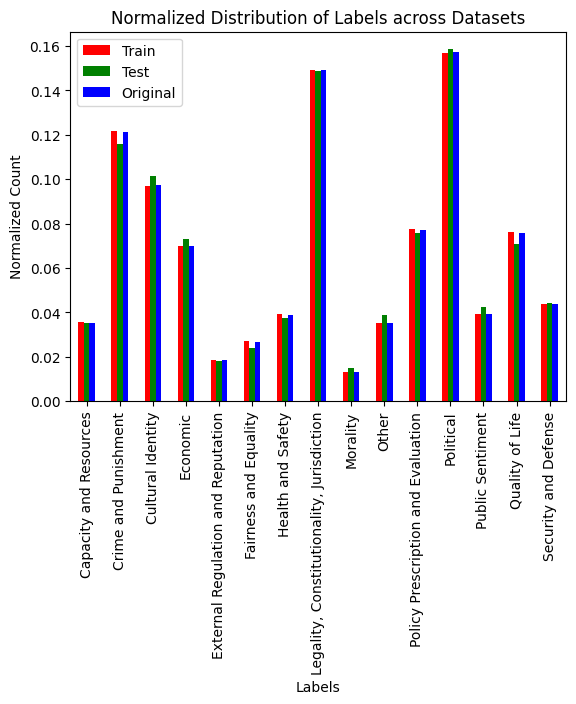

In [19]:
# visualize the distribution of labels for train and test and original

import matplotlib.pyplot as plt

# Count the frequency of each category normalized by the total counts
train_counts = y_train.value_counts(normalize=True)
test_counts = y_test.value_counts(normalize=True)
original_counts = data["document_frame"].value_counts(normalize=True)

# Create a combined DataFrame for easier plotting
combined = pd.DataFrame({
    "Train": train_counts,
    "Test": test_counts,
    "Original": original_counts
})

# Fill NaN values with 0 for any missing category in any dataset
combined.fillna(0, inplace=True)

# Plotting all in one plot with different colors
combined.plot(kind="bar", color=['red', 'green', 'blue'])
plt.title("Normalized Distribution of Labels across Datasets")
plt.xlabel("Labels")
plt.ylabel("Normalized Count")
plt.show()